# Modelling: desicion tree and random forest

In [101]:
import numpy as np #linear algebra
import pandas as pd #data processing
import seaborn as sns #visualization
import matplotlib.pyplot as plt #visualization
import plotly.express as px #visualization
import missingno as msno #missing no analysis

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold, train_test_split
from sklearn.metrics import precision_score, confusion_matrix

from sklearn import tree

df = pd.read_csv("cleaned_data.csv")

In [102]:
X = df.drop("Potability", axis = 1).values
y = df["Potability"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#her bir feature için min max değerleri buluyoruz
x_train_max = np.max(X_train)
x_train_min = np.min(X_train)

X_train = (X_train - x_train_min)/(x_train_max - x_train_min)
X_test = (X_test - x_train_min)/(x_train_max - x_train_min)


In [103]:
models = [("DTC", DecisionTreeClassifier(max_depth=10)),
          ("RF", RandomForestClassifier())]

finalResult = [] #score
cmList = [] #confusion matrix list

for name, model in models:
    model.fit(X_train, y_train) #training

    model_result = model.predict(X_test)
    score = precision_score(y_test, model_result)

    finalResult.append((name, score))

    cm = confusion_matrix(y_test, model_result)
    cmList.append((name, cm))

In [104]:
print(finalResult)

[('DTC', 0.6913183279742765), ('RF', 0.8029739776951673)]


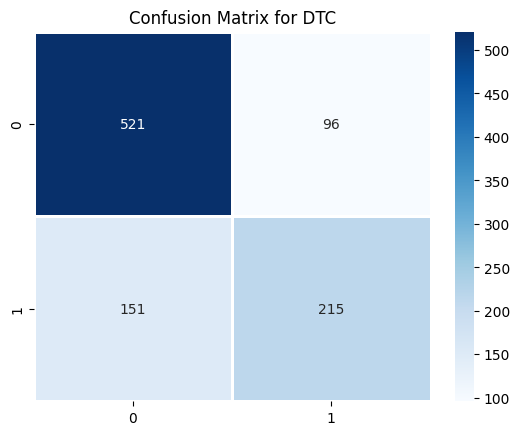

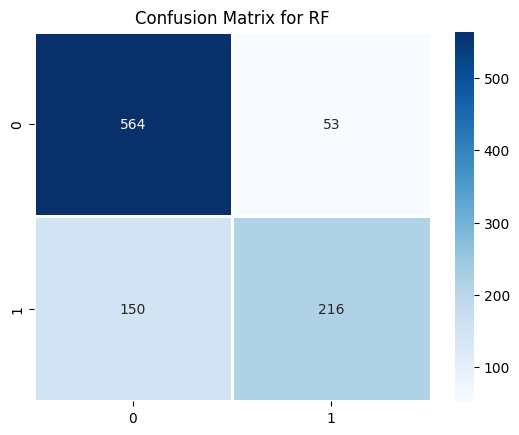

In [105]:
for name, cm in cmList:
    plt.figure()  # Yeni bir figür oluştur
    sns.heatmap(cm, annot=True, linewidths=0.8, fmt="d", cmap="Blues")  # fmt="d" tam sayı formatı
    plt.title(f"Confusion Matrix for {name}")
    
    # Heatmap'i dosya olarak kaydet
    filename = f"confusion_matrix_{name}.png"  # Dosya adı
    plt.savefig(filename, dpi=300, bbox_inches="tight")  # Dosyayı kaydet
    
    plt.show()  # Grafiği görüntüle

# Evaluation: desicion tree visualization

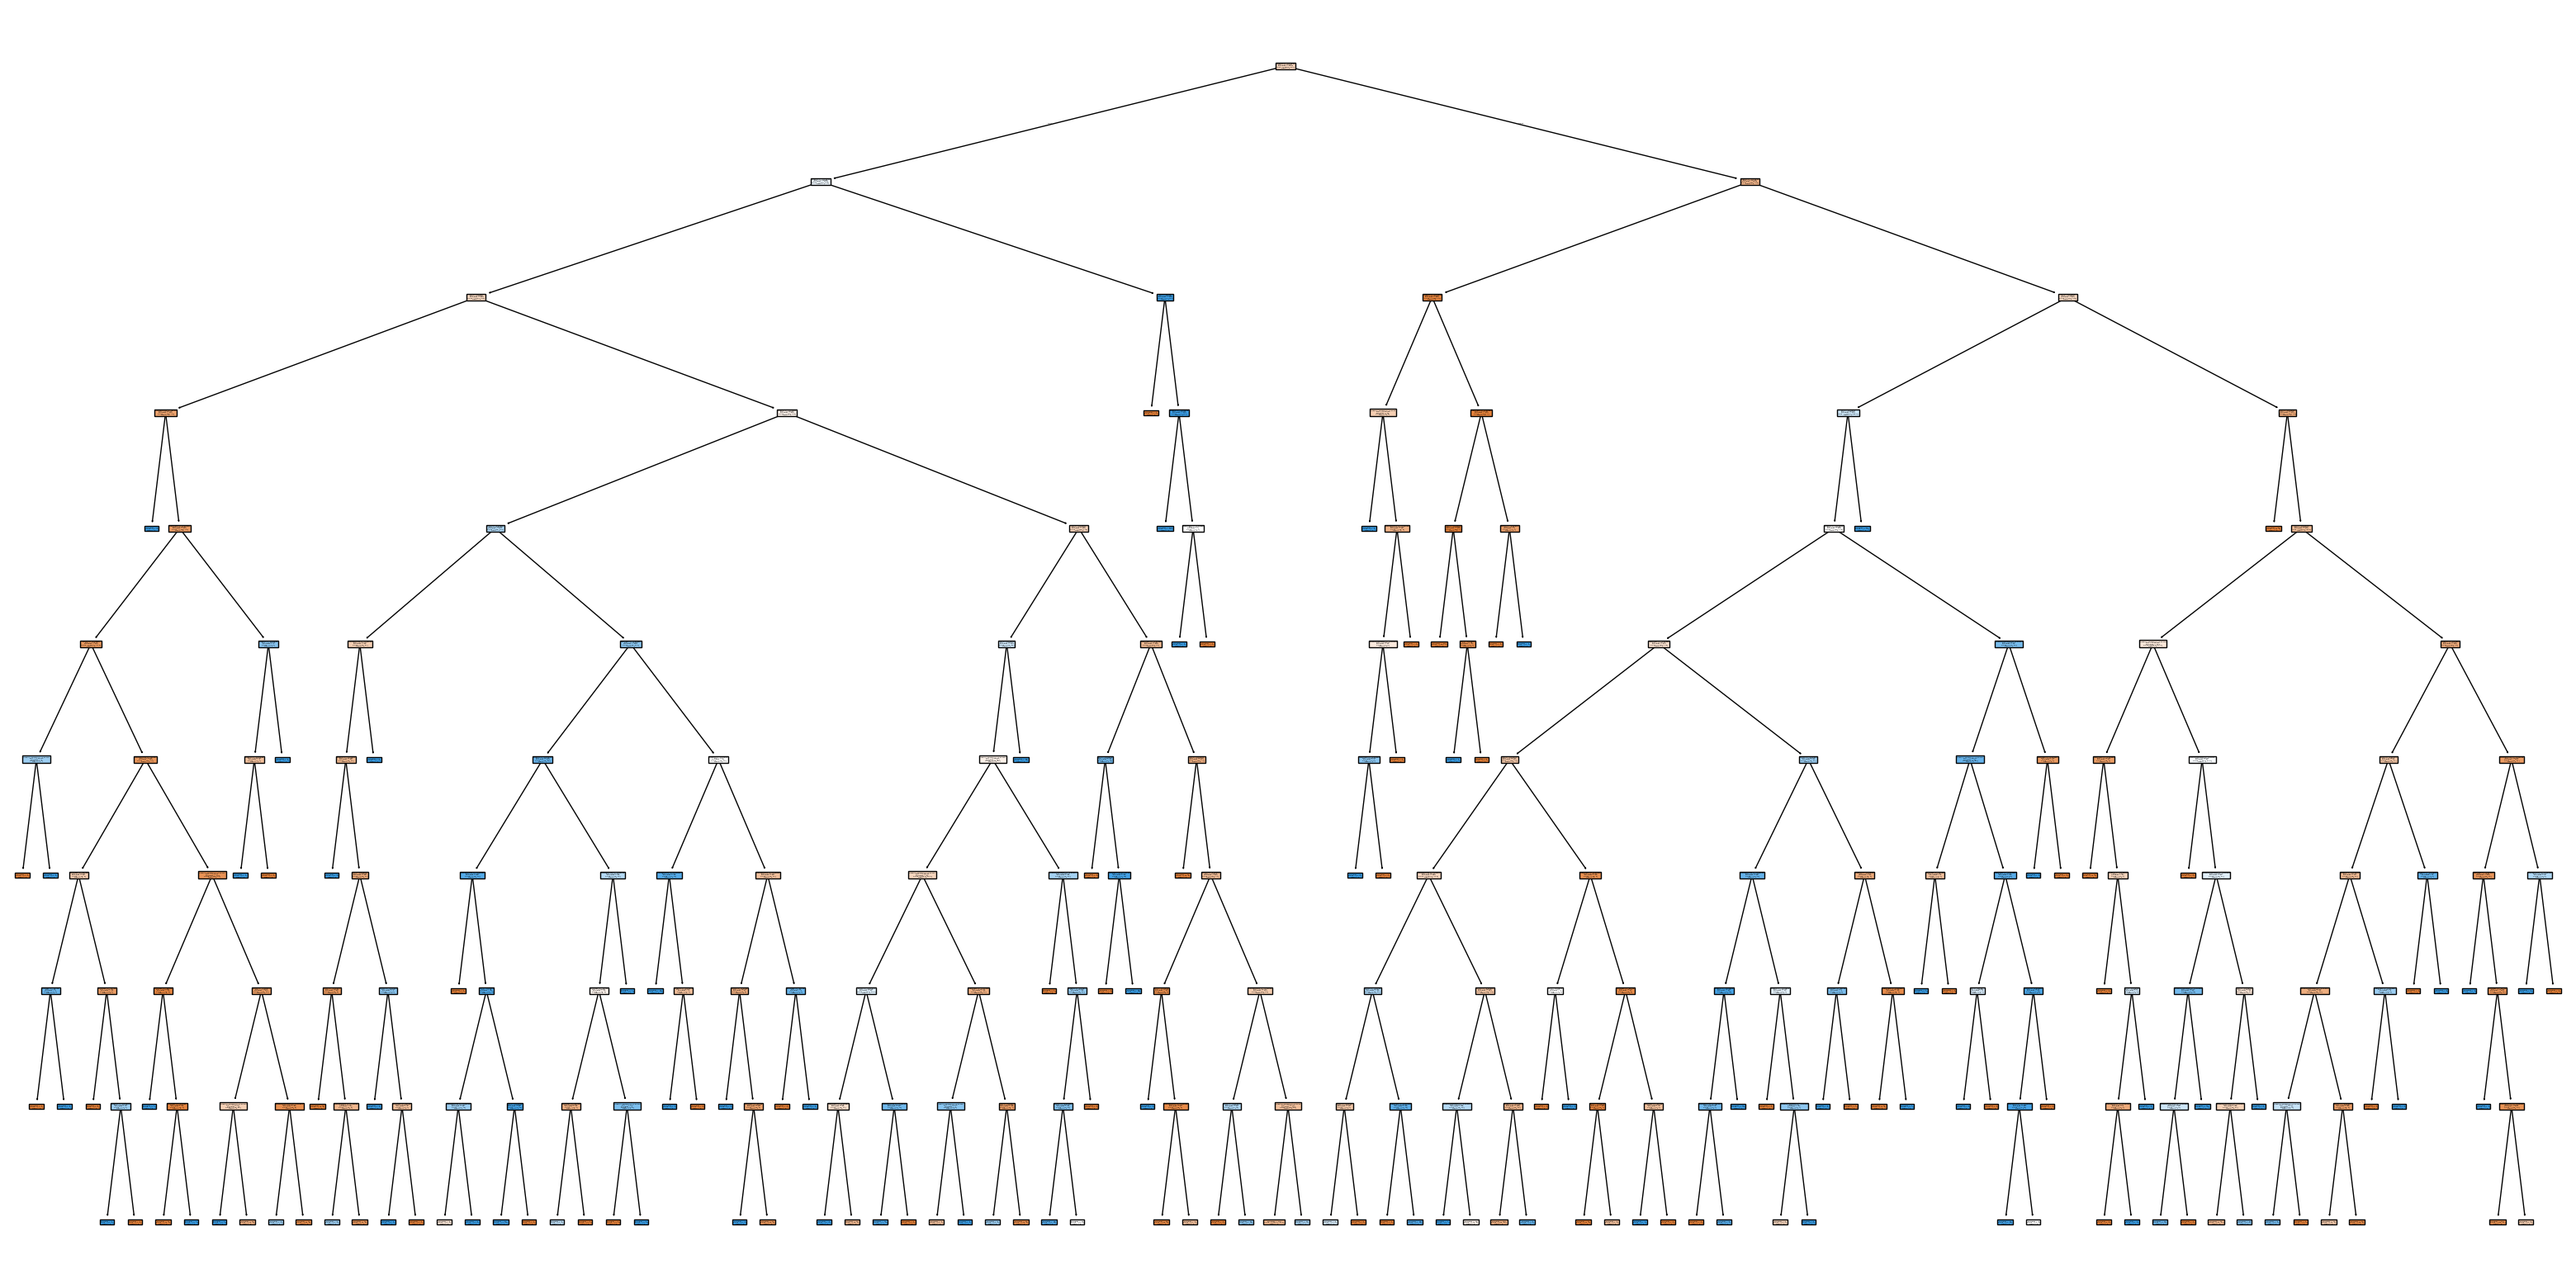

In [106]:
# DecisionTreeClassifier modelini seç
dt_clf = models[0][1]  # 'models' listesindeki ilk modelin sınıflandırıcı kısmını seçiyoruz.

# Yeni bir figür başlat
plt.figure(figsize=(40, 20))  # Görselin boyutunu artırdık, genişlik ve yükseklik büyütüldü.

# Decision Tree yapısını çiz
plot_tree(
    dt_clf,  # Çizilecek karar ağacı modeli
    feature_names=df.columns.tolist()[:-1],  # Özniteliklerin isimlerini belirt (son sütun hariç, çünkü o hedef değişken)
    class_names=["0", "1"],  # Modelin tahmin ettiği sınıfların isimleri
    filled=True,  # Düğümleri renklerle doldur (sınıf dağılımına göre)
    precision=5  # Gösterilen değerlerde 5 ondalık basamak kullan
)

# Grafiği bir PNG dosyasına kaydet
plt.savefig("decision_tree_high_quality.png", dpi=600, bbox_inches="tight")  # Daha yüksek DPI ile kaydet

# Grafiği göster
plt.show()  # Karar ağacı yapısını görselleştir.


# Hyperparameter tuning: random forest

In [108]:
# 1. Model parametrelerini belirtiyoruz
model_params = {
    "RandomForest": {  # Random Forest modeli için parametreleri tanımlıyoruz
        "model": RandomForestClassifier(),  # Kullanacağımız model
        "params": {  # Modelin hiperparametreleri
            "n_estimators": [10, 50, 100],  # Kaç adet ağaç kullanılacağı
            "max_features": ["auto", "sqrt", "log2"],  # Bölünme sırasında dikkate alınacak özelliklerin sayısı
            "max_depth": list(range(1, 21, 3))  # Ağaçların maksimum derinliği (1'den 20'ye kadar, 3'er artışlarla)
        }
    }
}

# 2. Çapraz doğrulama (Cross-validation) yöntemi tanımlıyoruz
cv = RepeatedStratifiedKFold(
    n_splits=5,  # Veri kümesini 5 parçaya böler
    n_repeats=2  # Çapraz doğrulamayı 2 kez tekrarlar
)

# 3. Skorları saklamak için bir liste oluşturuyoruz
scores = []

# 4. Model ve hiperparametre arama işlemi
for model_name, params in model_params.items():  # Her model ve hiperparametre kümesi için döngü
    # RandomizedSearchCV nesnesini tanımlıyoruz
    rs = RandomizedSearchCV(
        estimator=params["model"],  # Modeli burada belirtiyoruz (örneğin, RandomForestClassifier)
        param_distributions=params["params"],  # Hiperparametre aralıkları
        cv=cv,  # Çapraz doğrulama yöntemi
        n_iter=10,  # Hiperparametre araması için rastgele 10 kombinasyon denenecek
        random_state=42  # Rastgelelik için bir başlangıç değeri belirtiyoruz (sonuçların tekrar edilebilir olması için)
    )
    
    # Modeli veri kümesi üzerinde eğitiyoruz
    rs.fit(X, y)  # X: Özellikler, y: Etiketler (bağımlı değişken)

    # En iyi hiperparametreleri ve skorları kaydediyoruz
    scores.append([model_name, dict(rs.best_params_), rs.best_score_])

# 5. Skorları ekrana yazdırıyoruz
print(scores)  # Her model için en iyi hiperparametre kombinasyonu ve doğrulama skoru

"""[['RandomForest', {'n_estimators': 50, 'max_features': 'log2', 'max_depth': 13}, np.float64(0.7918239154719793)]]"""

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/

[['RandomForest', {'n_estimators': 50, 'max_features': 'log2', 'max_depth': 13}, np.float64(0.7918239154719793)]]


"[['RandomForest', {'n_estimators': 50, 'max_features': 'log2', 'max_depth': 7}, np.float64(0.7902911469000186)]] "